In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_absolute_error
import torch
import torch.nn as nn
import torch.utils.data as data_utils

In [2]:
torch.cuda.get_device_name(0)

'GeForce GTX 1060'

# Prep

In [3]:
# Define Data Builder
class build_data(BaseEstimator, TransformerMixin):
    """
    Loads and Prepares dataset for pytorch
    WMAE weights are last two values in y"""
    
    def __init__(self, df, drop, split_size=0.33, rand=22391, batch=1, shuffle=True, pin=True, ts_only=True, wt=True):
        self.wt = wt
        self.rand = rand
        self.split_size = split_size
        self.batch = batch
        self.shuffle = shuffle
        self.pin = pin
        self.ts = ts_only
        
        df = df.astype('float')
        
        ccols = [i for i in df.columns if 'Feature' in i]
        self.keep = [i for i in ccols if i not in drop]
        
        self.x = df.iloc[:,26:147] # time steps
        self.x2 = df.loc[:,self.keep] # other features
        self.y = df.iloc[:,147:]
               
    def _na_fill(self,mode):
        for i in self.x2.columns:
            if i in mode:
                self.x2[i] = self.x2[i].fillna(value=self.x2[i].mode()[0])
            else:
                self.x2[i] = self.x2[i].fillna(value=self.x2[i].median())
                
        self.x = self.x.interpolate(method='linear', axis=1)
        self.x_fin = pd.concat([self.x2,self.x], axis=1)
        
    def _split(self):
        X_train, X_test, y_train, y_test = train_test_split(self.x_fin, self.y, test_size=self.split_size, random_state=self.rand)

        # Seperate Features and TS
        self.X_train_ts = X_train.iloc[:,23:147]
        self.X_test_ts = X_test.iloc[:,23:147]

        self.X_train_ft = X_train.iloc[:,:23]
        self.X_test_ft = X_test.iloc[:,:23]

        # Get Weights for MAE
        # Weights also included in loader, be sure to index when running
        self.test_wt, self.train_wt = np.asarray(y_test.iloc[:,-2:]), np.asarray(y_train.iloc[:,-2:])
        self.y_test, self.y_train = np.asarray(y_test.iloc[:,:-2]), np.asarray(y_train.iloc[:,:-2])
        
    def _scale(self,stsc,lab,dev=True):
        ctrans =  ColumnTransformer(
                    [('scale_all', StandardScaler(), stsc),
                     ('cats', OneHotEncoder(categories='auto'), lab)])
        
        xtsc = StandardScaler()
        ytsc = StandardScaler()
        mmx = MinMaxScaler(feature_range=(-1,1))
        mmy = MinMaxScaler(feature_range=(-1,1))
        wtsc = StandardScaler(with_mean=False)
        
        self.X_train_ft = ctrans.fit_transform(self.X_train_ft)
        self.X_test_ft = ctrans.transform(self.X_test_ft)
        self.X_train_ts = xtsc.fit_transform(self.X_train_ts)
        self.X_test_ts = xtsc.transform(self.X_test_ts)
        
        self.X_train_ts = mmx.fit_transform(self.X_train_ts)
        self.X_test_ts = mmx.transform(self.X_test_ts)
       
        if self.ts:
            self.x_train = self.X_train_ts
            self.x_test = self.X_test_ts
        else:
            self.x_train = np.concatenate([self.X_train_ft, self.X_train_ts], axis=1)
            self.x_test = np.concatenate([self.X_test_ft, self.X_test_ts], axis=1)
        
        self.train_wt = wtsc.fit_transform(self.train_wt)
        self.test_wt = wtsc.transform(self.test_wt)
        
        self.y_train_sc = ytsc.fit_transform(self.y_train)
        self.y_test_sc = ytsc.transform(self.y_test)
        self.y_train_sc = mmy.fit_transform(self.y_train)
        self.y_test_sc = mmy.transform(self.y_test)
        
        if self.wt:
            self.y_train = np.concatenate([self.y_train,self.train_wt],axis=1)
            self.y_test = np.concatenate([self.y_test,self.test_wt],axis=1)
        
        self.xtrans_sc = xtsc
        self.xtrans_mm = mmx
        self.ytrans_mm = mmy
        self.ytrans_sc = ytsc
        self.ftrans = ctrans
        
    def fit(self, mode, stsc, lab):
        self._na_fill(mode)
        self._split()
        self._scale(stsc,lab)
        self.mode = mode
        
        torch_x_train, torch_y_train = torch.from_numpy(self.x_train).float(), torch.from_numpy(self.y_train_sc).float()
        torch_x_test, torch_y_test = torch.from_numpy(self.x_test).float(), torch.from_numpy(self.y_test_sc).float()
        torch_x_train = torch_x_train.view(-1,1,121)
        torch_x_test = torch_x_test.view(-1,1,121)
        
        train = data_utils.TensorDataset(torch_x_train, torch_y_train)
        test = data_utils.TensorDataset(torch_x_test, torch_y_test)
        
        train_loader = data_utils.DataLoader(train, batch_size=self.batch, shuffle=self.shuffle, pin_memory=self.pin)
        test_loader = data_utils.DataLoader(test, batch_size=self.batch, shuffle=self.shuffle, pin_memory=self.pin)
        
        return train_loader, test_loader
    
    def fit_sub(self, sub_df, ft=False):
        sub_df = sub_df.astype('float')
        sub_x = sub_df.iloc[:,26:147] # time steps
        sub_x2 = sub_df.loc[:,self.keep] # other features
        
        # Fill NA
        for i in sub_x2.columns:
            if i in self.mode:
                sub_x2[i] = sub_x2[i].fillna(value=sub_x2[i].mode()[0])
            else:
                sub_x2[i] = sub_x2[i].fillna(value=sub_x2[i].median())
                
        sub_x = sub_x.interpolate(method='linear', axis=1)
        
        # Scale
        sub_x = self.xtrans_sc.transform(sub_x)
        sub_x = self.xtrans_mm.transform(sub_x)
        sub_x2 = self.ftrans.transform(sub_x2)
        if ft:
            sub = np.concatenate([sub_x2, sub_x], axis=1)
        else:
            sub = sub_x
        
        # Make loader
        sub = torch.from_numpy(sub).float()
        sub_ds = data_utils.TensorDataset(sub)
        sub_loader = data_utils.DataLoader(sub_ds, batch_size=self.batch, shuffle=False, pin_memory=self.pin)
        
        return sub_loader
        
    def get_weights(self):
        return self.train_wt, self.test_wt
    
    def reverse_trans(self, x=False, y=False):
        if x is not False and y is not False:
            return self.xtrans.inverse_transform(x), self.ytrans.inverse_transform(y)
        elif x is not False:
            return self.xtrans.inverse_transform(x)
        elif y is not False:
            return self.ytrans.inverse_transform(y)
        
    def make_sub(sub, fn, path=r"C:\Users\rlagr\fin\winton\data\\"):
        sub = self.ytrans_mm.inverse_transform(sub)
        sub = self.ytrans_sc.inverse_transform(sub)
        sub = sub.reshape(-1,1)

        win = [i for i in range(1,120001)]
        step = [i for i in range(1,63)]
        rnames = [None] * sub.shape[0]

        ind = 0

        for i in win:
            for k in step:
                name = str(i) + '_' + str(k)
                rnames[ind] = name
                ind += 1

        s = pd.DataFrame(rnames)
        s.columns = ['Id']
        s['Predicted'] = sub
        path = path + fn

        s.to_csv(path, index=False)


In [4]:
# Define Custom Loss function
class wmae_loss(torch.nn.Module):
    def __init__(self):
        super(wmae_loss,self).__init__()
        
    def _wmae(self,pred, true, wts):
        """Second weight for last 2 preds, first for rest"""
        n = true.shape[0] * true.shape[1]
        intra = torch.sum(wts[0] * torch.abs(true[:,:-2] - pred[:-2]))
        daily = torch.sum(wts[1] * torch.abs(true[:,-2:] - pred[-2:]))
        return (intra + daily) / n
        
    def forward(self, pred, true, wt):
        return self._wmae(pred, true, wt)

Using this custom WMAE with the weights provided doesn't seem to have any noticable effect.  The net is still converging at predicting zero across the outputs.

In [5]:
class mod_mse(torch.nn.Module):
    def __init__(self, l1=1, l2=1):
        super(mod_mse, self).__init__()
        self.l1 = l1
        self.l2 = l2
        
    def _mod(self, pred, true):
        pred[pred == 0] = .000001
        return self.l1 * torch.mean(torch.abs(1 - (true/pred))) + self.l2 * torch.mean((pred-true)**2)
    
    def forward(self, pred, true):
        return self._mod(pred,true)

This loss function was made in an attempt to punish inaccurate predictions that were close to zero.  Another variation where the two terms were multiplied was also tried but both had the effect of just shifting the predictions up to a small positive number (like 1 or 2) but didn't encourage making them with any greater magnitude.  For now it's probably best to just stick to standard MSE but this loss function may be helpful later when a different way of encouraging higher magnitude predictions can be found. 

In [6]:
def predict(model, dat, act=False, sub=False):
    model.eval()
    res = []
    y_out = []
    if sub:
        for i, x in enumerate(dat):
            x = x[0].view(-1,1,121)
            x = x.cuda()
            out = model(x)
            out = out.cpu().data.numpy()
            res.append(out)
            
    else:
        for i, (x,y) in enumerate(dat):
            true = y[:,:-2].cuda()
            wts = torch.flatten(y[:,-2:]).cuda()
            x = x.view(-1,1,121)
            x = x.cuda()
            out = model(x)
            out = out.cpu().data.numpy()
            res.append(out)

            if act:
                true = torch.flatten(true)
                true = true.cpu().data.numpy()
                y_out.append(true)
    
    res = np.array(res)
    if act:
        y_out = np.array(y_out)
        return res, y_out
    else:
        return res
    

In [7]:
path = r"C:\Users\rlagr\fin\winton\data\train.csv"
#path = r"C:\Users\RemyLagrois\!pytorch\data\train.csv"
exclude = ['Feature_1', 'Feature_10']
mode = ['Feature_9', 'Feature_13', 'Feature_16', 'Feature_20']
cats = ['Feature_5', 'Feature_13', 'Feature_16', 'Feature_20']
scale = ['Feature_2', 'Feature_3', 'Feature_4', 'Feature_6', 'Feature_8', 'Feature_11', 'Feature_12', 'Feature_14', 'Feature_17', 'Feature_18',
         'Feature_19', 'Feature_21', 'Feature_22', 'Feature_23', 'Feature_24', 'Feature_25', 'Feature_7', 'Feature_9', 'Feature_15']

# Dev Data
df = pd.read_csv(path)
data = build_data(df, exclude, wt=False)

train_loader, test_loader = data.fit(mode, scale, cats)

# Submission Data
#sub_set = pd.read_csv(r"C:\Users\rlagr\fin\winton\data\test_2.csv")
#sub_load = data.fit_sub(sub_set)

As seen previously none of the architectures jumped out as being especially good and had a tendancy to train towards zero.  Here I have defined the custom loss function; it's a WMAE where the intra-day minute time steps get one weight and the final two full day returns get another.  I will define a 1d CNN similar to the one in Keras and see if this loss function leads to any better fits.

In [8]:
nn.init.calculate_gain('leaky_relu', 0.01)

1.4141428569978354

# Define Model

In [9]:
torch.cuda.empty_cache()

In [10]:
class CNN_1d(nn.Module):
    
    def __init__(self, kernels, filters, hidden):
        super(CNN_1d, self).__init__()
        
        self.cnn = nn.Sequential() # contains convolutional 
        self.reg = nn.Sequential() # layers to process conv features
        self.lin_in = 60 * filters[-1]
        gain = nn.init.calculate_gain('leaky_relu', 0.01)

        # Create Conv layers
        for i, k in enumerate(kernels):
            pad = int((k - 1) / 2)
            if i == 0: # First conv layer
                conv = nn.Conv1d(1, filters[i], k, 1, padding=pad)
            else: # subsequent
                conv = nn.Conv1d(filters[i-1], filters[i], k, 1, pad)
            nn.init.xavier_normal_(conv.weight,gain=gain)
            self.cnn.add_module('conv-' + str(i + 1), conv)
            self.cnn.add_module('lrel' + str(i + 1), nn.LeakyReLU(negative_slope=.01))
            self.cnn.add_module('bn-'+ str(i +1), nn.BatchNorm1d(filters[i]))
        self.cnn.add_module('mpool', nn.MaxPool1d(2)) # final max pool
       # self.cnn.add_module('cnn-drp', nn.Dropout(p=0.5))
        
        # Add input layer to feed forward section
        lin = nn.Linear(self.lin_in, hidden[0])
        nn.init.normal_(lin.weight,std=.005)
        self.reg.add_module('FF-in', lin)
        self.reg.add_module('in-lrel', nn.SELU())
       # self.reg.add_module('in-drp'+ str(i +1), nn.Dropout(p=0.5))
        
        # Create FC/output layers
        for i, k in enumerate(hidden):
            if i < (len(hidden) - 1):
                hid = nn.Linear(k, hidden[i + 1])
                nn.init.normal_(hid.weight,std=.005)
                self.reg.add_module('hid-' + str(i+1), hid)
                self.reg.add_module('h-lrel-' + str(i+1), nn.Tanh())
               # self.reg.add_module('drp-'+ str(i +1), nn.Dropout(p=0.25,inplace=False))
                
            elif i == (len(hidden) - 1): # Last layer for output
                hid = nn.Linear(k, 62)
                nn.init.normal_(hid.weight,std=.005)

                self.reg.add_module('out', hid)
                
                
    def forward(self, x):
        x = self.cnn(x)
        x = x.view(-1,1,self.lin_in)
        x = self.reg(x)
        x = torch.flatten(x)
        
        return x
    

Weight Initialization is starting to look like the key to getting predictions that are not close to zero.  The net is very sensitive to the starting values though with distributions containing values greater than +/- 1 producing predictions on the order of 10^5 or greater.  Using Xavier normal with the proper gain for LReLU with neg slope = 0.1 on the convolutions, Uniform from +/- 1.01 on the hidden layers, and normal with mean = 0 and std = 1.1 on the output is producing predictions about in the range of +/- 10-20 after 100 epochs.  This method seems to at least be on the right track; avoiding the zero prediction valley by converging on the correct predictions from above and below is looking like the best method.  Once the starting conditions have been tuned a bit to not require so many epochs it may be a good idea to re-implement the modified MSE to prevent overshooting correct predictions.  The training appears to mostly be modifying weights close to the output, the last hidden layer (hid-5) becomes more normally distributed with weights ranging from +/- 4 while the earlier hidden layers stay closer to uniform with ranges about the same as their starting conditions (though at a lower frequency).  The final linear layer stays normally distributed but with very small weights ranging from ~ +/- 0.02.  

Running Xavier Uniform as before, uniform +/- 0.9 on the hidden layers, and normal mean = 0 with std = 0.85 on the final layer produced predictions in the correct range after 70 epochs.  However the loss spiked a lot which would seem to indicate an overly aggressive learning rate.  I suspect the submission predictions won't score as well as straight zero guesses since it doesn't appear to match up extremely well.  The patterns in the weights from the previous experiment held.  For this round the uniform weights will be increased back up to 1.01 but the std for the final layer will be made much smaller.  Finally layer 5 will be switched to a normal distribution with an std of ~1.  

Xavier, uniform +/- 1.01, normal on the last hidden layer with std=1, and normal on the output with std=0.1 seems to be right about where we want to be. THe last hidden layer weights are getting smaller than they were before though.  It's not obvious if this is a good or bad thing. The eval data isn't keeping up as well and after ~40 epochs it's going past where we'd like.  Tuning other hyper parameters is likely the best next step and using the modified MSE function may also help keep predictions where we want them. 

After trying several variations I've come to believe getting very good predictions out of a single model is unlikely.  Instead an ensamble will be used so getting predictions consistently shaped like the true values is more important that very close predictions.  The models in each ensamble will try to extract different features from the data and use those for their individual predictions before being combined.  For this reason I have decided to change the architecture to deep convolution with minimal FC layers.  This will hopefully extract complex temporal features which can atleast capture the character of the time series.  One of the other models will contain one of the variations of an autoencoder (possibly including the features that go along with each series) to learn features that aren't nessicarily spatial/temporal.  

Added minmax scale to -1,1.

Trying Tanh - this causes the custom loss to not work due to inplace operation


In [11]:
kernels = [5,5,5,5,5,5,5,5]
filters = [4,4,4,8,8,8,16,16]
hidden = [500,62]

cnn1 = CNN_1d(kernels, filters, hidden)
cnn1 = cnn1.cuda()

#loss_fnA = mod_mse().cuda()
loss_fnB = nn.MSELoss().cuda()
opt_alg = torch.optim.RMSprop(cnn1.parameters(), lr=.001)
opt = torch.optim.lr_scheduler.MultiStepLR(opt_alg, milestones=[5,15,30])

print(cnn1)

CNN_1d(
  (cnn): Sequential(
    (conv-1): Conv1d(1, 4, kernel_size=(5,), stride=(1,), padding=(2,))
    (lrel1): LeakyReLU(negative_slope=0.01)
    (bn-1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv-2): Conv1d(4, 4, kernel_size=(5,), stride=(1,), padding=(2,))
    (lrel2): LeakyReLU(negative_slope=0.01)
    (bn-2): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv-3): Conv1d(4, 4, kernel_size=(5,), stride=(1,), padding=(2,))
    (lrel3): LeakyReLU(negative_slope=0.01)
    (bn-3): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv-4): Conv1d(4, 8, kernel_size=(5,), stride=(1,), padding=(2,))
    (lrel4): LeakyReLU(negative_slope=0.01)
    (bn-4): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv-5): Conv1d(8, 8, kernel_size=(5,), stride=(1,), padding=(2,))
    (lrel5): LeakyReLU(negative_slope=0.01)
    (bn-5): BatchNorm1d(8, 

starting epoch  1
	iteration 0 -- 0.0466151088476181
	iteration 5000 -- 0.0027424977339000956
	iteration 10000 -- 0.0025914945264871505
	iteration 15000 -- 0.0025244815919225447
	iteration 20000 -- 0.002490947629979003
	iteration 25000 -- 0.002460279741276859


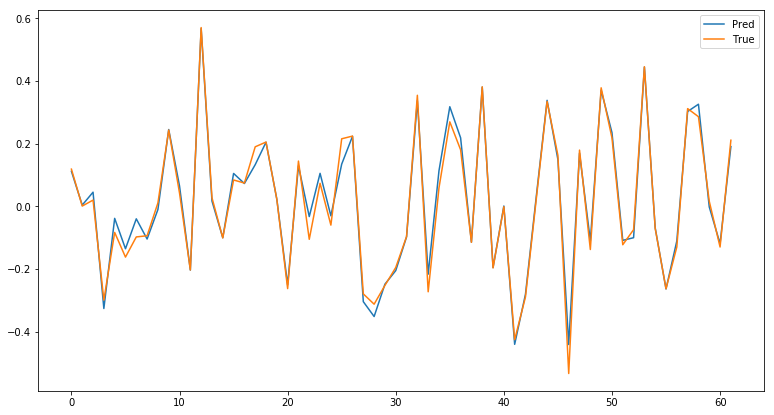

Epoch 1/10, Training Loss: 0.00245, Testing Loss: 0.00298, Test MAE (plotted): 0.020
starting epoch  2
	iteration 0 -- 0.0003689127042889595
	iteration 5000 -- 0.0025406716220101296
	iteration 10000 -- 0.0025254609107616603
	iteration 15000 -- 0.0024743356254069322
	iteration 20000 -- 0.0024661011112342714
	iteration 25000 -- 0.0024262384553256785
Epoch 2/10, Training Loss: 0.00243, Testing Loss: 0.00300, Test MAE (plotted): 0.019
starting epoch  3
	iteration 0 -- 0.00017552416829857975
	iteration 5000 -- 0.0025113292607048935
	iteration 10000 -- 0.0024109707760305832
	iteration 15000 -- 0.0024714580765034847
	iteration 20000 -- 0.0024622817522316183
	iteration 25000 -- 0.002436872446947279
Epoch 3/10, Training Loss: 0.00243, Testing Loss: 0.00299, Test MAE (plotted): 0.026
starting epoch  4
	iteration 0 -- 0.0004889834090135992
	iteration 5000 -- 0.0024528654060182297
	iteration 10000 -- 0.0024054350421593234
	iteration 15000 -- 0.0024896638990386994
	iteration 20000 -- 0.002456278553

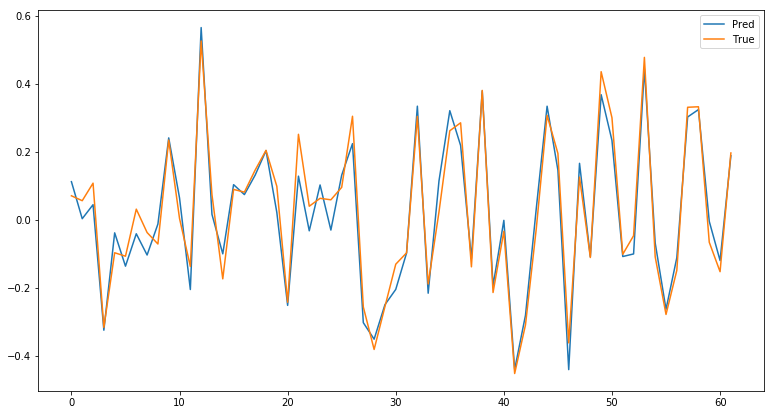

Epoch 6/10, Training Loss: 0.00243, Testing Loss: 0.00301, Test MAE (plotted): 0.042
starting epoch  7
	iteration 0 -- 0.0010862986091524363
	iteration 5000 -- 0.002549591125156042
	iteration 10000 -- 0.002446485786563652
	iteration 15000 -- 0.0024037857065573893
	iteration 20000 -- 0.0023813151339863808
	iteration 25000 -- 0.002394906075990949
Epoch 7/10, Training Loss: 0.00243, Testing Loss: 0.00301, Test MAE (plotted): 0.048
starting epoch  8
	iteration 0 -- 0.00048382082604803145
	iteration 5000 -- 0.002457266775043225
	iteration 10000 -- 0.002419217403581992
	iteration 15000 -- 0.002412403284706766
	iteration 20000 -- 0.0023945749121927046
	iteration 25000 -- 0.0024371248464850922
Epoch 8/10, Training Loss: 0.00243, Testing Loss: 0.00301, Test MAE (plotted): 0.021
starting epoch  9
	iteration 0 -- 0.0011311153648421168
	iteration 5000 -- 0.0026072764658360004
	iteration 10000 -- 0.0025466485646105275
	iteration 15000 -- 0.0024991055073361255
	iteration 20000 -- 0.00244408224730272

In [12]:
#Training the CNN
num_epochs = 10

#Define the lists to store the results of loss and accuracy

losses = {'train_loss' : [None]*num_epochs , 'eval_loss' : [None]*num_epochs}

#Training
for epoch in range(num_epochs): 
    
    print('starting epoch ', str(epoch + 1))
    iterations = 0
    iter_loss = 0.0
    
    cnn1.train()
    for i, (x,y) in enumerate(train_loader):

        true = y.cuda(non_blocking=True)
        true = torch.flatten(true)
        x = x.view(-1,1,121)
        x = x.cuda(non_blocking=True)
        opt_alg.zero_grad()
        out = cnn1(x)
        #lossA = loss_fnA(out, true)
        loss = loss_fnB(out, true)
       # loss = lossA + lossB
        
        iter_loss += loss.item()
        loss.backward()
        opt_alg.step()
        opt.step()
        
        iterations += 1
        if i % 5000 == 0:
            print('\titeration', str(i), '--', str(iter_loss/iterations))
        
    losses['train_loss'][epoch] = iter_loss / iterations

    # Test
    cnn1.eval()
    ev_loss = 0.0
    iterations = 0
    
    for i, (x,y) in enumerate(test_loader):
        
        true = y.cuda(non_blocking=True)
        true = torch.flatten(true)
        x = x.view(-1,1,121)
        x = x.cuda(non_blocking=True)
        out = cnn1(x)
        #loss = loss_fnA(out, true)
        loss = loss_fnB(out, true)
        #loss = lossA + lossB
        ev_loss += loss.item()
        
        iterations += 1
    
    if epoch % 5 == 0:
        tst_plt = out.cpu().data.numpy()
        tr_plt = true.cpu().data.numpy()
        tst_plt = tst_plt.reshape(-1,62)
        tr_plt = tr_plt.reshape(-1,62)
        plt.figure(figsize=(13,7))
        plt.plot(tst_plt[0], label="Pred")
        plt.plot(tr_plt[0], label='True')
        plt.legend()
        plt.show()
    
    losses['eval_loss'][epoch] = ev_loss / iterations
    mae = mean_absolute_error(out.cpu().data.numpy(), true.cpu().data.numpy())
    
    print ('Epoch {}/{}, Training Loss: {:.5f}, Testing Loss: {:.5f}, Test MAE (plotted): {:.3f}'
           .format(epoch+1, num_epochs, losses['train_loss'][epoch], losses['eval_loss'][epoch], mae))
    

In [19]:
mean_absolute_error(out.cpu().data.numpy(), true.cpu().data.numpy())

5.256239

In [ ]:
tot_train = losses['train_loss']
tot_eval = losses['eval_loss'],
plt.figure(figsize=(10,10))
plt.plot(losses['train_loss'], label='Training Loss')
plt.plot(losses['eval_loss'], label='Testing Loss')
plt.legend()
plt.show()

In [76]:
test = test.reshape(-1,62)
test.shape

(13200, 62)

In [ ]:
plt.figure(figsize=(13,7))
test, test2 = predict(cnn1, test_loader, True)
test = test.reshape(-1,62)
plt.plot(test[30], label='Pred')
plt.plot(test2[30], label='True')
plt.legend()
plt.show()

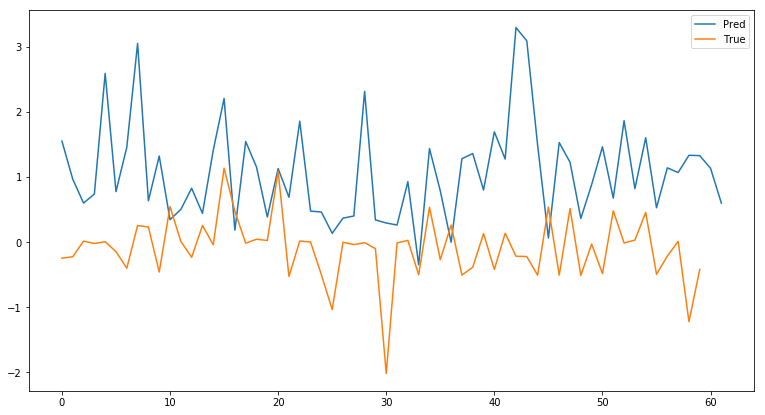

In [28]:
plt.figure(figsize=(13,7))
#test, test2 = predict(cnn1, test_loader, True)
#test = test.reshape(-1,62)
plt.plot(test[30], label='Pred')
plt.plot(test2[30], label='True')
plt.legend()
plt.show()

In [29]:
np.mean(test)

1.3240939

In [ ]:
np.mean(test)

In [22]:
hid_1_w = cnn1.state_dict()['reg.FF-in.weight'].cpu()

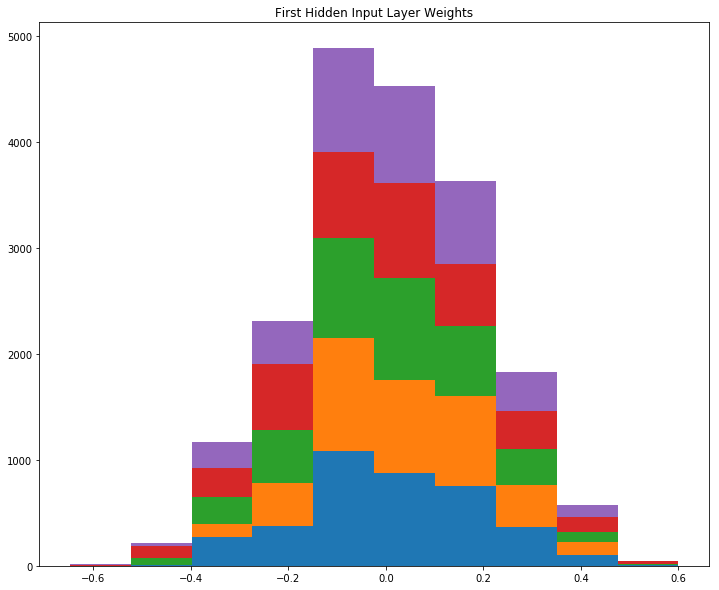

In [23]:
plt.figure(figsize=(12,10))
plt.hist(hid_1_w[15:20], stacked=True)
plt.title('First Hidden Input Layer Weights')
plt.show()

In [ ]:
reg_hid3_w = cnn1.state_dict()['reg.out.weight'].cpu()

In [ ]:
plt.figure(figsize=(12,10))
plt.hist(reg_hid3_w[15:20], stacked=True)
plt.title('Regression Hidden Layer Weights')
plt.show()

In [23]:
reg_hid5_w = cnn1.state_dict()['reg.hid-1.weight'].cpu()

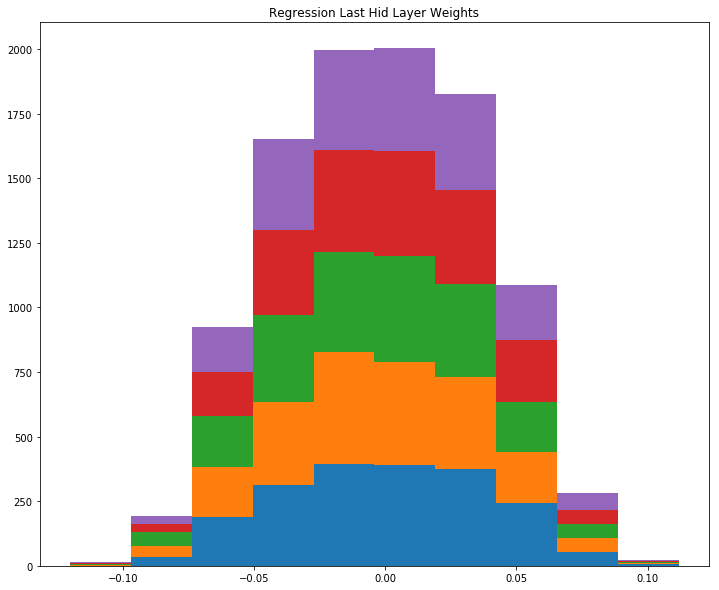

In [24]:
plt.figure(figsize=(12,10))
plt.hist(reg_hid5_w[15:20], stacked=True)
plt.title('Regression Last Hid Layer Weights')
plt.show()

In [24]:
reg_out_w = cnn1.state_dict()['reg.out.weight'].cpu()

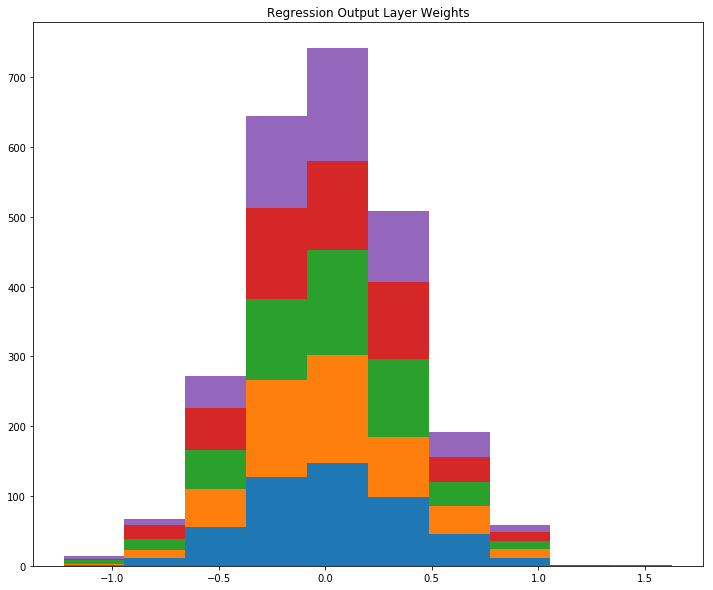

In [25]:
plt.figure(figsize=(12,10))
plt.hist(reg_out_w[15:20], stacked=True)
plt.title('Regression Output Layer Weights')
plt.show()

In [52]:
#cnn_3 = cnn1.state_dict()['cnn.conv-1.weight'].cpu()

~ 15 epochs

CNN_1d(
  (cnn): Sequential(
    (conv-1): Conv1d(1, 4, kernel_size=(3,), stride=(1,), padding=(1,))
    (lrel1): LeakyReLU(negative_slope=0.01)
    (bn-1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv-2): Conv1d(4, 4, kernel_size=(3,), stride=(1,), padding=(1,))
    (lrel2): LeakyReLU(negative_slope=0.01)
    (bn-2): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv-3): Conv1d(4, 4, kernel_size=(3,), stride=(1,), padding=(1,))
    (lrel3): LeakyReLU(negative_slope=0.01)
    (bn-3): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv-4): Conv1d(4, 8, kernel_size=(3,), stride=(1,), padding=(1,))
    (lrel4): LeakyReLU(negative_slope=0.01)
    (bn-4): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv-5): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=(1,))
    (lrel5): LeakyReLU(negative_slope=0.01)
    (bn-5): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv-6): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=(1,))
    (lrel6): LeakyReLU(negative_slope=0.01)
    (bn-6): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv-7): Conv1d(8, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (lrel7): LeakyReLU(negative_slope=0.01)
    (bn-7): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv-8): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (lrel8): LeakyReLU(negative_slope=0.01)
    (bn-8): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv-9): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (lrel9): LeakyReLU(negative_slope=0.01)
    (bn-9): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv-10): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (lrel10): LeakyReLU(negative_slope=0.01)
    (bn-10): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv-11): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (lrel11): LeakyReLU(negative_slope=0.01)
    (bn-11): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv-12): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (lrel12): LeakyReLU(negative_slope=0.01)
    (bn-12): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv-13): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (lrel13): LeakyReLU(negative_slope=0.01)
    (bn-13): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (mpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (reg): Sequential(
    (FF-in): Linear(in_features=3840, out_features=2000, bias=True)
    (in-lrel): LeakyReLU(negative_slope=0.01)
    (in-drp13): Dropout(p=0.25, inplace=False)
    (hid-1): Linear(in_features=2000, out_features=1500, bias=True)
    (h-lrel-1): LeakyReLU(negative_slope=0.01)
    (drp-1): Dropout(p=0.25, inplace=False)
    (hid-2): Linear(in_features=1500, out_features=1000, bias=True)
    (h-lrel-2): LeakyReLU(negative_slope=0.01)
    (drp-2): Dropout(p=0.25, inplace=False)
    (hid-3): Linear(in_features=1000, out_features=500, bias=True)
    (h-lrel-3): LeakyReLU(negative_slope=0.01)
    (drp-3): Dropout(p=0.25, inplace=False)
    (out): Linear(in_features=500, out_features=62, bias=True)
  )
)


In [138]:
def make_sub(sub, fn):
    sub = data.reverse_trans(y=sub)
    sub = sub.reshape(-1,1)

    win = [i for i in range(1,120001)]
    step = [i for i in range(1,63)]
    rnames = [None] * sub.shape[0]

    ind = 0

    for i in win:
        for k in step:
            name = str(i) + '_' + str(k)
            rnames[ind] = name
            ind += 1

    s = pd.DataFrame(rnames)
    s.columns = ['Id']
    s['Predicted'] = sub
    path = r"C:\Users\rlagr\fin\winton\data\\"
    path = path + fn
    
    s.to_csv(path, index=False)

In [ ]:
it = 0
for i in sub_load:
    if it == 1:
        break
    
    print(i[0].view(-1,1))
    it += 1

In [140]:
#sub_f = predict(cnn1, sub_load, sub=True)

make_sub(sub_f, fn="pytorch_cnn1_winit.csv")